In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from scipy.stats import linregress
import scipy.stats as st
import json
import requests
import hvplot.pandas
from citipy import citipy
from pprint import pprint
from api_keys import US_Census_key
from api_keys import geoapify_key
from api_keys import weather_api_key

In [2]:
# Import data source 
# (Ref:Source: US Department of Transportation, Federal Highway Administration
# (https://www.fhwa.dot.gov/bipartisan-infrastructure-law/evs_5year_nevi_funding_by_state.cfm)

source_df = pd.read_csv("Resources/Original_National EV Infrastructure Funding by State.csv")

# Remove last row
clean_df = source_df.drop(index=[52])

# Replace "Dist. of Col." with "District of Columbia"
clean_df["State"] = clean_df["State"].str.replace("Dist. of Col.","District of Columbia")

# remove commas from numbers and convert to float
clean_df["Actual FY 2022"] = clean_df["Actual FY 2022"].str.replace(",","")
clean_df["Estimated FY 2023"] = clean_df["Estimated FY 2023"].str.replace(",","")
clean_df["Estimated FY 2024"] = clean_df["Estimated FY 2024"].str.replace(",","")
clean_df["Estimated FY 2025"] = clean_df["Estimated FY 2025"].str.replace(",","")
clean_df["Estimated FY 2026"] = clean_df["Estimated FY 2026"].str.replace(",","")
clean_df["Estimated Total"] = clean_df["Estimated Total"].str.replace(",","")

# Convert object values to float
clean_df["Actual FY 2022"] = clean_df["Actual FY 2022"].astype(int)
clean_df["Estimated FY 2023"] = clean_df["Estimated FY 2023"].astype(int)
clean_df["Estimated FY 2024"] = clean_df["Estimated FY 2024"].astype(int)
clean_df["Estimated FY 2025"] = clean_df["Estimated FY 2025"].astype(int)
clean_df["Estimated FY 2026"] = clean_df["Estimated FY 2026"].astype(int)
clean_df["Estimated Total"] = clean_df["Estimated Total"].astype(int)

# # print to csv file and screen file
clean_df.to_csv("Resources/Clean_National_EV_Infrastructure_Funding_Dataset.csv", index_label="Index")
clean_df.head()

/var/folders/m7/yfqdhr1157x_5xx3bb3y5s940000gn/T/ipykernel_11606/3934399870.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  clean_df["State"] = clean_df["State"].str.replace("Dist. of Col.","District of Columbia")


,State,Actual FY 2022,Estimated FY 2023,Estimated FY 2024,Estimated FY 2025,Estimated FY 2026,Estimated Total
0,Alabama,11738801,16892267,16892384,16892399,16892434,79308285
1,Alaska,7758240,11164195,11164272,11164282,11164305,52415294
2,Arizona,11320762,16290704,16290816,16290830,16290864,76483976
3,Arkansas,8010850,11527704,11527783,11527793,11527817,54121947
4,California,56789406,81720595,81721161,81721230,81721400,383673792


In [3]:
# read merge datasource
merge_source = pd.read_csv("Resources/Pulled_EV_Final.csv")
merge_source.head()

,State,Registrations of EV 2019,Registrations of EV 2020,Registrations of EV 2021,Total EV,YOY(2020-2021)Growth Percentage,2019 - No. EV charge outlets,2020 - No. EV charge outlets,2021 - No. EV charge outlets,Total charging outlets,EV:Charger outlets,Average fuel price(current),Capital,ST,Lat,Lon
0,Alabama,722,2890.0,4750.0,8362.0,64.40%,506.0,596.0,680.0,1782.0,4.69,$3.08,Montgomery,AL,32.366966,-86.300648
1,Alaska,87,940.0,1290.0,2317.0,37.23%,34.0,45.0,94.0,173.0,13.39,$4.31,Juneau,AK,58.301950,-134.419734
2,Arizona,6637,28770.0,40740.0,76147.0,41.61%,1476.0,1778.0,2257.0,5511.0,13.82,$3.79,Phoenix,AZ,33.448437,-112.074141
3,Arkansas,370,1330.0,2390.0,4090.0,79.70%,290.0,350.0,453.0,1093.0,3.74,$3.09,Little Rock,AR,34.746507,-92.289627
4,California,100549,425300.0,563070.0,1088919.0,32.40%,27128.0,34622.0,41225.0,102975.0,10.57,$4.87,Sacramento,CA,38.581061,-121.493895


In [4]:
# keep required columns only "Lat", "Lon"
new_merge = merge_source[["State","Lat","Lon"]]
new_merge.head(3)


,State,Lat,Lon
0,Alabama,32.366966,-86.300648
1,Alaska,58.301950,-134.419734
2,Arizona,33.448437,-112.074141


In [5]:
# merge "Lat" and "Lon" to clean_df
funding_df = pd.merge(clean_df,new_merge,how="left",on="State")

# drop "nan" rows
clean_funding_df = funding_df.dropna(subset="Lat")

# set State as index
clean_funding_df1=clean_funding_df.set_index("State")
clean_funding_df1

# sort data set by Estimated total funding
Top_5_funding = clean_funding_df1.sort_values(by="Estimated Total", ascending=False)
Top_5_funding.head(5)


,Actual FY 2022,Estimated FY 2023,Estimated FY 2024,Estimated FY 2025,Estimated FY 2026,Estimated Total,Lat,Lon
State,,,,,,,,
Texas,60356706,86853980,86854582,86854655,86854836,407774759,30.271129,-97.743700
California,56789406,81720595,81721161,81721230,81721400,383673792,38.581061,-121.493895
Florida,29315442,42185251,42185543,42185579,42185666,198057481,30.438083,-84.280933
New York,25971644,37373488,37373747,37373779,37373856,175466514,42.651167,-73.754968
Pennsylvania,25386631,36531648,36531901,36531932,36532008,171514120,40.266311,-76.886112


In [6]:
###GET POPULATION DATA FROM API TO ADD TO DATASET

In [7]:
# Base url

base_url = "https://api.census.gov/data/2021/pep/population?get=NAME,POP_2021&for=state&key=ddaeb0b8ea290503730d5e88987cf4f4829355a0"

# call data from API 
    
query = requests.get(base_url)
response = query.json()

Population_df = pd.DataFrame(response)
Population_df.columns = ["State","Est Population 2021", "State_No"]

# Remove first row
Population_df = Population_df.drop(index=[0])
Population_df

# read merge population data to main datasource
pop_funding_df = pd.merge(clean_funding_df1,Population_df,how="left",on="State")
final_funding_df = pop_funding_df.sort_values(by="Estimated Total", ascending=False)

# convert population from type "string" to type "int"
final_funding_df["Est Population 2021"] = final_funding_df["Est Population 2021"].astype(int)

# Calculate Avg spend per capita
final_funding_df["Avg Funding per Capita"]=final_funding_df["Estimated Total"]/final_funding_df["Est Population 2021"]

# Remove first row, Alaska and Hawaii
final_funding_df = final_funding_df.drop(index=[1,10])
#final_funding_df_csv("Resources/EV_Funding.csv", index_label="Index")
final_funding_df.head(5)




,State,Actual FY 2022,Estimated FY 2023,Estimated FY 2024,Estimated FY 2025,Estimated FY 2026,Estimated Total,Lat,Lon,Est Population 2021,State_No,Avg Funding per Capita
42,Texas,60356706,86853980,86854582,86854655,86854836,407774759,30.271129,-97.743700,29527941,48,13.809793
4,California,56789406,81720595,81721161,81721230,81721400,383673792,38.581061,-121.493895,39237836,06,9.778159
8,Florida,29315442,42185251,42185543,42185579,42185666,198057481,30.438083,-84.280933,21781128,12,9.093077
31,New York,25971644,37373488,37373747,37373779,37373856,175466514,42.651167,-73.754968,19835913,36,8.845901
37,Pennsylvania,25386631,36531648,36531901,36531932,36532008,171514120,40.266311,-76.886112,12964056,42,13.229974


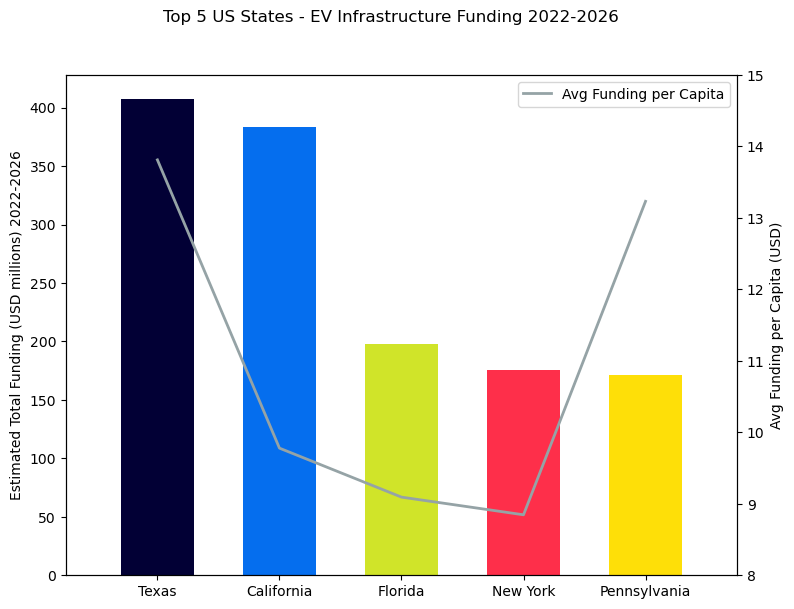

In [8]:
# prepare bar chart Top 5 states by Estimated Total Funding
#  Code Ref:  CoderzColumn, 31 December 2021,"Secondary x & Y Axis Python", e (https://www.youtube.com/watch?v=Ys0JbzGk8E4), accessed 19 July 2023
# format Estimated Totals by dividing by 1 million

funding_by_state_chart = final_funding_df.head(5)

# Set fig size
fig, ax_main = plt.subplots(figsize=(8.66, 6.5))

# set colors for States

Texas = "#020035"
Cali = "#056eee"
Florida = "#d0e429"
New_York ="#fe2f4a"
Penn = "#fedf08"

# Set bar positions and width
bar_positions = np.arange(len(funding_by_state_chart))
bar_width = 0.6

# Plot primary axis
x_axis_State = funding_by_state_chart["State"].tolist()
y_axis_Funding = funding_by_state_chart["Estimated Total"] / 1_000_000
tick_State = funding_by_state_chart["State"].tolist()

plt.xlim(-0.75, len(x_axis_State) - 0.25)
plt.ylabel("Estimated Total Funding (USD millions) 2022-2026")

plt.bar(bar_positions, y_axis_Funding, color=[Texas, Cali, Florida, New_York, Penn], align="center", width=bar_width)

plt.xticks(bar_positions, tick_State)
plt.suptitle("Top 5 US States - EV Infrastructure Funding 2022-2026")

# Plot secondary axis
ax2 = ax_main.twinx()
x2_axis = funding_by_state_chart["State"]
y2_axis = funding_by_state_chart["Avg Funding per Capita"]
ax2.set_ylabel("Avg Funding per Capita (USD)")
ax2.set_ylim(8, 15)
ax2.plot(x2_axis,y2_axis, color="#95a3a6", linewidth=2, label="Avg Funding per Capita")
ax2.legend()

# Export chart to file & display
plt.savefig("Output_Data/Chart_EV_Inf_Funding_by_State.png")
plt.show()


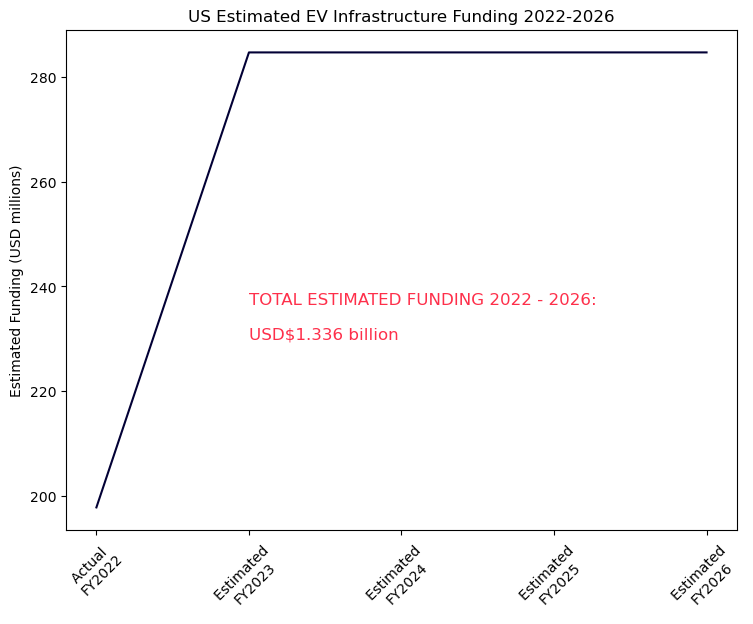

In [9]:
# Configure Chart total spend over period 2022 to 202
# Create the figure and set its size
plt.figure(figsize=(8.66, 6.5))

_2022 = funding_by_state_chart["Actual FY 2022"].sum()/1_000_000
_2023 = funding_by_state_chart["Estimated FY 2023"].sum()/1_000_000
_2024 = funding_by_state_chart["Estimated FY 2024"].sum()/1_000_000
_2025 = funding_by_state_chart["Estimated FY 2025"].sum()/1_000_000
_2026 = funding_by_state_chart["Estimated FY 2026"].sum()/1_000_000
_2026 = funding_by_state_chart["Estimated FY 2026"].sum()/1_000_000
_Total = funding_by_state_chart["Estimated Total"].sum()/1_000_000_000

ypoints = np.array([_2022, _2023, _2024, _2025, _2026])
years = ["Actual \nFY2022", "Estimated \nFY2023", "Estimated \nFY2024", "Estimated \nFY2025", "Estimated \nFY2026"]

plt.plot(years, ypoints, color="#020035") 
plt.ylabel("Estimated Funding (USD millions)")
plt.title("US Estimated EV Infrastructure Funding 2022-2026")
plt.xticks(years, rotation=45) 
plt.annotate(f"TOTAL ESTIMATED FUNDING 2022 - 2026:\n\nUSD${_Total:.3f} billion",
             xy=("Estimated \nFY2023", 240), xytext=("Estimated \nFY2023", 230),
             color="#fe2f4a", fontsize=12)

# Save the plot and display
plt.savefig("Output_Data/Chart_EV_Funding22-26.png")
plt.show()


In [10]:
# Configure Chart spend per capita by State - hv plot
final_funding_df["Lat"]
final_funding_df["Lon"]

Spend_chart = final_funding_df.hvplot.points(
    "Lon",
    "Lat",
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500,
    xlabel = " ",
    ylabel = " ",
    size = "Estimated Total",
    color = "State",
    title = "Estimated Total EV Infrastructure Funding 2022-2026 by State",
    hover_cols = ["Actual FY 2022", "Estimated FY 2023", "Estimated FY 2024", "Estimated FY 2025", "Estimated FY 2026"],
    scale = 0.0015)

# display and export chart
hvplot.save(Spend_chart, "Output_Data/Chart_Ttl_EV_Funding_hvplot_map.png")
Spend_chart

/Users/mireille.walton/anaconda3/envs/Bootcamp/lib/python3.10/site-packages/geoviews/operation/__init__.py:14: HoloviewsDeprecationWarning: 'ResamplingOperation' is deprecated and will be removed in version 1.17, use 'ResampleOperation2D' instead.
  from holoviews.operation.datashader import (


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lon,Lat]   (State,Estimated Total,Actual FY 2022,Estimated FY 2023,Estimated FY 2024,Estimated FY 2025,Estimated FY 2026)

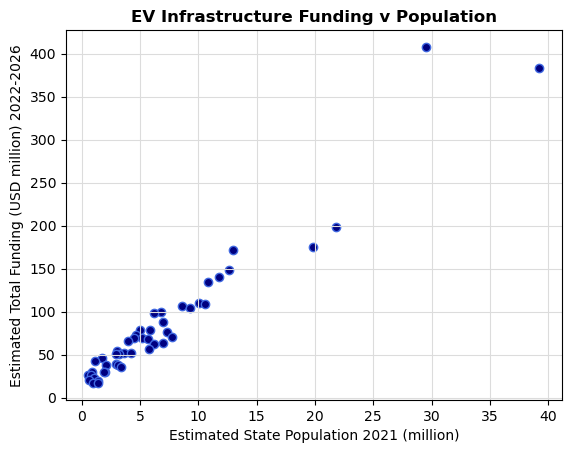

In [11]:
# create scatter chart for funding v population - format to millions
funding22_26 = (final_funding_df["Estimated Total"]/1_000_000)
est_pop21 = (final_funding_df["Est Population 2021"]/1_000_000)
plt.scatter(est_pop21, funding22_26, edgecolor = "royalblue", color = "navy", marker="o")
# Incorporate the other graph properties
plt.title("EV Infrastructure Funding v Population", weight = "bold")
plt.ylabel("Estimated Total Funding (USD million) 2022-2026")
plt.xlabel("Estimated State Population 2021 (million)")
plt.grid(True, color = "gainsboro")

# export chart to file & display
plt.savefig("Output_Data/Chart_EV_Inf_Pop.png")

# Show plot

plt.show()

/var/folders/m7/yfqdhr1157x_5xx3bb3y5s940000gn/T/ipykernel_11606/625470521.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_axis, LR_regress_val, "r-",color="red")


The r-value is: 0.97


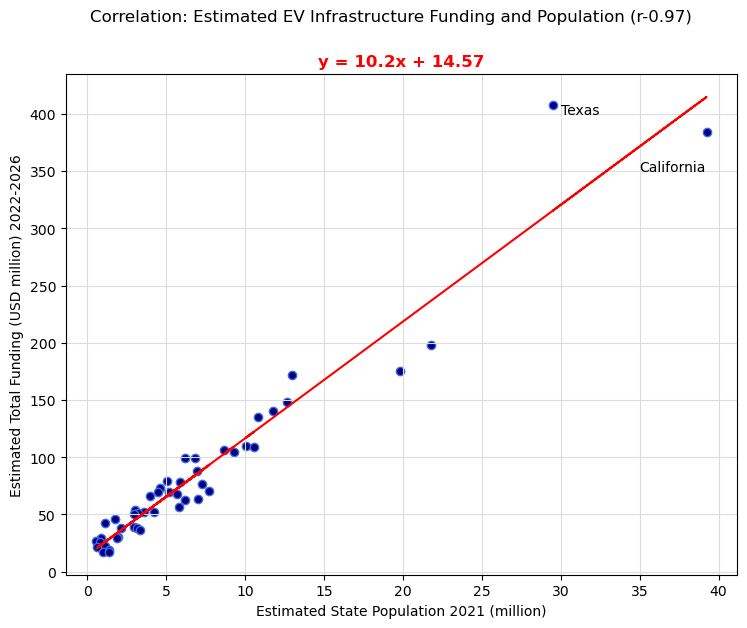

In [12]:
# investigate correlation between spend and State population

x_axis = est_pop21
y_axis = funding22_26
plt.figure(figsize=(8.66, 6.5))

#def lin_regress(x_axis, y_axis, title, y_title):     
    
# calculate linear regression 
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis, y_axis)
LR_regress_val = x_axis * slope + intercept
LR_line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
R_val = st.pearsonr(x_axis, y_axis)
plt.scatter(x_axis, y_axis, edgecolor = "royalblue", color = "navy", marker="o")
plt.annotate('California', xy =(35, 350),
                xytext =(35, 350))
plt.annotate('Texas', xy =(39, 400),
                xytext =(30, 400))
R_val = st.pearsonr(x_axis, y_axis)
    
#plot linear regression 
plt.plot(x_axis, LR_regress_val, "r-",color="red")
print (f"The r-value is: {round(R_val[0], 2)}")
plt.suptitle("Correlation: Estimated EV Infrastructure Funding and Population (r-0.97)"
 + "\n")
plt.title(LR_line_eq, weight='bold', color='red')
plt.ylabel("Estimated Total Funding (USD million) 2022-2026")
plt.xlabel("Estimated State Population 2021 (million)")
plt.grid(True, color = "gainsboro")

# export chart to file & display
plt.savefig("Output_Data/Chart_EV_Inf_Pop_LR.png")
plt.show()  

In [13]:
#Prepare extra charts - population and Total Charging Outlets per Captita
# read merge datasource
merge_source1 = pd.read_csv("Resources/Pulled_EV_Final.csv")
sort_outlet_top5_df = pd.merge(final_funding_df, merge_source1, how="left",on="State")
outlet_top5_df = sort_outlet_top5_df.sort_values(by="Total charging outlets", ascending=False)

# Calculate average number of charging outlets per capita
outlet_top5_df["Avg Charge Outlets per Capita"]=outlet_top5_df["Total charging outlets"]/(outlet_top5_df["Est Population 2021"]/100_000)
outlet_top5_df.head(5)




,State,Actual FY 2022,Estimated FY 2023,Estimated FY 2024,Estimated FY 2025,Estimated FY 2026,Estimated Total,Lat_x,Lon_x,Est Population 2021,...,2020 - No. EV charge outlets,2021 - No. EV charge outlets,Total charging outlets,EV:Charger outlets,Average fuel price(current),Capital,ST,Lat_y,Lon_y,Avg Charge Outlets per Capita
1,California,56789406,81720595,81721161,81721230,81721400,383673792,38.581061,-121.493895,39237836,...,34622.0,41225.0,102975.0,10.57,$4.87,Sacramento,CA,38.581061,-121.493895,262.438020
3,New York,25971644,37373488,37373747,37373779,37373856,175466514,42.651167,-73.754968,19835913,...,6092.0,7621.0,18244.0,5.11,$3.68,Albany,NY,42.651167,-73.754968,91.974592
2,Florida,29315442,42185251,42185543,42185579,42185666,198057481,30.438083,-84.280933,21781128,...,5519.0,6723.0,16804.0,9.93,$3.46,Tallahassee,FL,30.438083,-84.280933,77.149356
0,Texas,60356706,86853980,86854582,86854655,86854836,407774759,30.271129,-97.743700,29527941,...,4802.0,5486.0,14297.0,9.55,$3.16,Austin,TX,30.271129,-97.743700,48.418547
19,Washington,10489110,15093948,15094052,15094065,15094096,70865271,47.045102,-122.895008,7738692,...,3771.0,4328.0,11305.0,11.29,$4.96,Olympia,WA,47.045102,-122.895008,146.084119


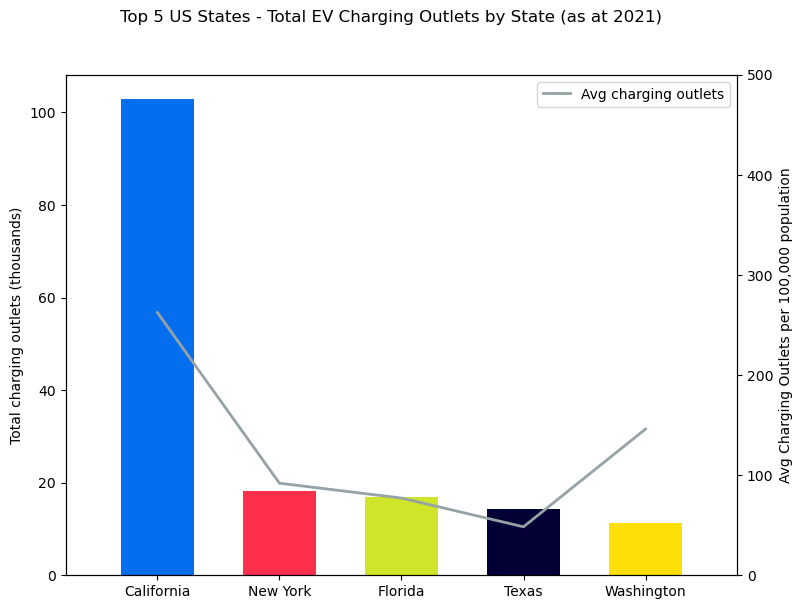

In [19]:
# prepare bar chart Top 5 states by Estimated Total Charging Outlets
#  Code Ref:  CoderzColumn, 31 December 2021,"Secondary x & Y Axis Python", e (https://www.youtube.com/watch?v=Ys0JbzGk8E4), accessed 19 July 2023
# format Estimated Totals by dividing by 1 million

Avg_Outlets_chart = outlet_top5_df.head(5)

# Set fig size
fig, ax_main = plt.subplots(figsize=(8.66, 6.5))

# set colors for States

Texas = "#020035"
Cali = "#056eee"
Florida = "#d0e429"
New_York ="#fe2f4a"
Washington = "#fedf08"

# Set bar positions and width
bar_positions = np.arange(len(Avg_Outlets_chart))
bar_width = 0.6

# Plot primary axis
x_axis_State = Avg_Outlets_chart["State"].tolist()
y_axis_Funding = Avg_Outlets_chart["Total charging outlets"] / 1_000
tick_State = Avg_Outlets_chart["State"].tolist()

plt.xlim(-0.75, len(x_axis_State) - 0.25)
plt.ylabel("Total charging outlets (thousands)")

plt.bar(bar_positions, y_axis_Funding, color=[Cali, New_York, Florida, Texas, Washington], align="center", width=bar_width)

plt.xticks(bar_positions, tick_State)
plt.suptitle("Top 5 US States - Total EV Charging Outlets by State (as at 2021)")

# Plot secondary axis
ax2 = ax_main.twinx()
x2_axis = Avg_Outlets_chart["State"]
y2_axis = Avg_Outlets_chart["Avg Charge Outlets per Capita"]
ax2.set_ylabel("Avg Charging Outlets per 100,000 population")
ax2.set_ylim(0, 500)
leg=plt.plot(x2_axis, y2_axis, color="#95a3a6", linewidth=2, label="Avg charging outlets")
ax2.legend()

# Export chart to file & display
plt.savefig("Output_Data/Chart_AvgOutletsPerCapita.png")
plt.show()

/var/folders/m7/yfqdhr1157x_5xx3bb3y5s940000gn/T/ipykernel_11606/138986632.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_axis, LR_regress_val, "r-",color="red")


The r-value is: 0.8


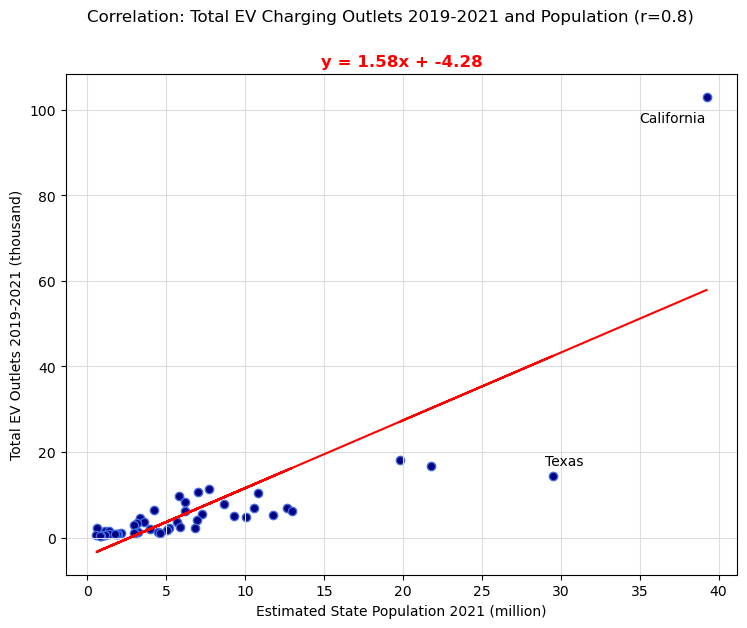

In [20]:
# create scatter chart for funding v population - format to millions
ttl_outlets = (outlet_top5_df["Total charging outlets"]/1_000)
est_pop21 = (outlet_top5_df["Est Population 2021"]/1_000_000)
# 
x_axis = est_pop21
y_axis = ttl_outlets
plt.figure(figsize=(8.66, 6.5))

#def lin_regress(x_axis, y_axis, title, y_title):     
    
# calculate linear regression 
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis, y_axis)
LR_regress_val = x_axis * slope + intercept
LR_line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
R_val = st.pearsonr(x_axis, y_axis)
plt.scatter(x_axis, y_axis, edgecolor = "royalblue", color = "navy", marker="o")
R_val = st.pearsonr(x_axis, y_axis)
    
#plot linear regression 

plt.plot(x_axis, LR_regress_val, "r-",color="red")
print (f"The r-value is: {round(R_val[0], 2)}")
plt.suptitle("Correlation: Total EV Charging Outlets 2019-2021 and Population (r=0.8)"
 + "\n" )
plt.title(LR_line_eq, weight='bold', color='red')
plt.ylabel("Total EV Outlets 2019-2021 (thousand)")
plt.xlabel("Estimated State Population 2021 (million)")
plt.grid(True, color = "gainsboro")
plt.annotate('California', xy =(35, 97),
                xytext =(35, 97))
plt.annotate('Texas', xy =(29, 17),
                xytext =(29, 17))

# export chart to file & display
plt.savefig("Output_Data/Chart_Corr_Outlet_Pop.png")
plt.show()  

In [16]:
#Prepare extra charts - population and Total Charging Outlets per Captita
# read merge datasource and merge with population data
merge_source2 = pd.read_csv("Resources/Pulled_Ev_Registrations.csv", encoding='iso-8859-1')
merge_source2.columns = merge_source2.columns.str.replace("#", "Number")
reg_merge=merge_source2.iloc[:,[0,4]]
reg_chartdata = pd.merge(final_funding_df, reg_merge, how="left",on="State")

# retain required columns
reg_chartdata1 = reg_chartdata.iloc[:,[0,9,12]]

# change datatype from object to string

reg_chartdata1.iloc[:, 2] = reg_chartdata1.iloc[:, 2].str.replace(',', '').astype(int)
top5_reg = reg_chartdata1.sort_values(by=reg_chartdata1.columns[2], ascending=False)

# # Calculate average number of charging outlets per capita
top5_reg["Avg Registrations per Capita"]=reg_chartdata1["Number of EV registrations (2021)"]/(reg_chartdata1["Est Population 2021"]/100_000)
top5_reg1=top5_reg.sort_values(by="Number of EV registrations (2021)", ascending=False)
top5_reg1.head(5)



/var/folders/m7/yfqdhr1157x_5xx3bb3y5s940000gn/T/ipykernel_11606/1728164270.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_chartdata1.iloc[:, 2] = reg_chartdata1.iloc[:, 2].str.replace(',', '').astype(int)


,State,Est Population 2021,Number of EV registrations (2021),Avg Registrations per Capita
1,California,39237836,563070,1435.017976
2,Florida,21781128,95640,439.095716
0,Texas,29527941,80900,273.977789
19,Washington,7738692,66810,863.324190
3,New York,19835913,51870,261.495400


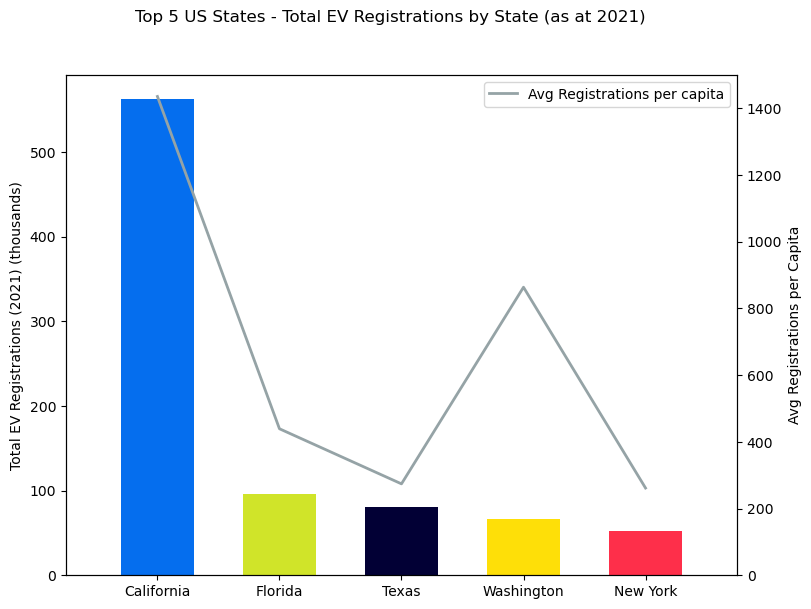

In [17]:
# prepare bar chart Top 5 states by Estimated Total Charging Outlets
#  Code Ref:  CoderzColumn, 31 December 2021,"Secondary x & Y Axis Python", e (https://www.youtube.com/watch?v=Ys0JbzGk8E4), accessed 19 July 2023
# format Estimated Totals by dividing by 1 million

Avg_reg = top5_reg1.head(5)

# Set fig size
fig, ax_main = plt.subplots(figsize=(8.66, 6.5))

# set colors for States

Texas = "#020035"
Cali = "#056eee"
Florida = "#d0e429"
New_York ="#fe2f4a"
Washington = "#fedf08"

# Set bar positions and width
bar_positions = np.arange(len(Avg_reg))
bar_width = 0.6

# Plot primary axis
x_axis_State = Avg_reg["State"]
y_axis_Funding = Avg_reg["Number of EV registrations (2021)"]/1_000
tick_State = Avg_reg["State"]

plt.xlim(-0.75, len(x_axis_State) - 0.25)
plt.ylabel("Total EV Registrations (2021) (thousands)")

plt.bar(bar_positions, y_axis_Funding, color=[Cali, Florida, Texas, Washington, New_York], align="center", width=bar_width)

plt.xticks(bar_positions, tick_State)
plt.suptitle("Top 5 US States - Total EV Registrations by State (as at 2021)")

# Plot secondary axis
ax2 = ax_main.twinx()
x2_axis = Avg_reg["State"]
y2_axis = Avg_reg["Avg Registrations per Capita"]
ax2.set_ylabel("Avg Registrations per Capita")
ax2.set_ylim(0, 1500)
leg=plt.plot(x2_axis, y2_axis, color="#95a3a6", linewidth=2, label="Avg Registrations per capita")
ax2.legend()

# Export chart to file & display
plt.savefig("Output_Data/Chart_AvgRegistrationsPerCapita.png")
plt.show()

/var/folders/m7/yfqdhr1157x_5xx3bb3y5s940000gn/T/ipykernel_11606/4019668422.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_axis, LR_regress_val, "r-",color="red")


The r-value is: 0.53


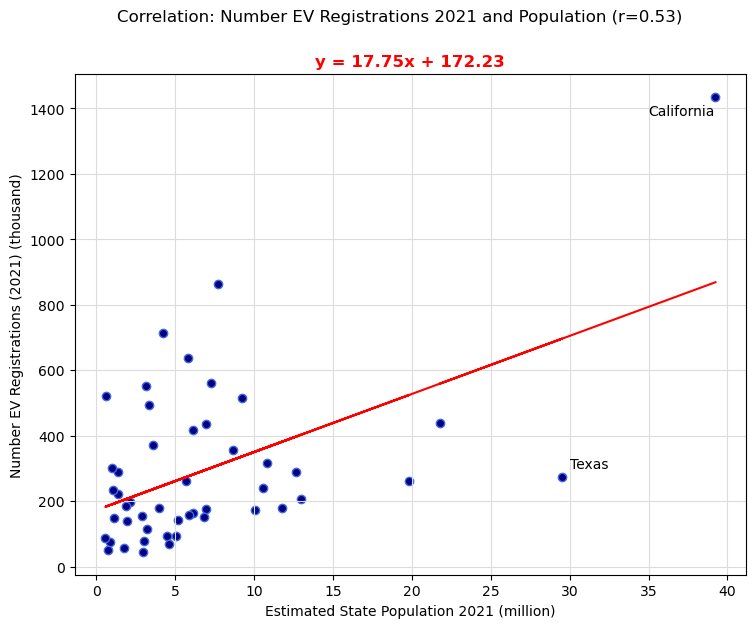

In [18]:
#Prepare extra charts - population and Total Charging Outlets per Captita
# read merge datasource


# create scatter chart for funding v population - format to millions
ttl_reg = top5_reg["Avg Registrations per Capita"]
est_pop21 = (top5_reg["Est Population 2021"]/1_000_000)
plt.figure(figsize=(8.66, 6.5))

x_axis = est_pop21
y_axis = ttl_reg


#def lin_regress(x_axis, y_axis, title, y_title):     
    
# calculate linear regression 
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis, y_axis)
LR_regress_val = x_axis * slope + intercept
LR_line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
R_val = st.pearsonr(x_axis, y_axis)
plt.scatter(x_axis, y_axis, edgecolor = "royalblue", color = "navy", marker="o")
R_val = st.pearsonr(x_axis, y_axis)
    
#plot linear regression 
plt.plot(x_axis, LR_regress_val, "r-",color="red")
print (f"The r-value is: {round(R_val[0], 2)}")
plt.suptitle("Correlation: Number EV Registrations 2021 and Population (r=0.53)"
 + "\n")
plt.title(LR_line_eq, weight='bold', color='red')
plt.ylabel("Number EV Registrations (2021) (thousand)")
plt.xlabel("Estimated State Population 2021 (million)")
plt.grid(True, color = "gainsboro")
plt.annotate('California', xy =(35, 1380),
                xytext =(35, 1380))
plt.annotate('Texas', xy =(35, 300),
                xytext =(30, 300))

# export chart to file & display
plt.savefig("Output_Data/Chart_Corr_Reg_Pop.png")
plt.show() 